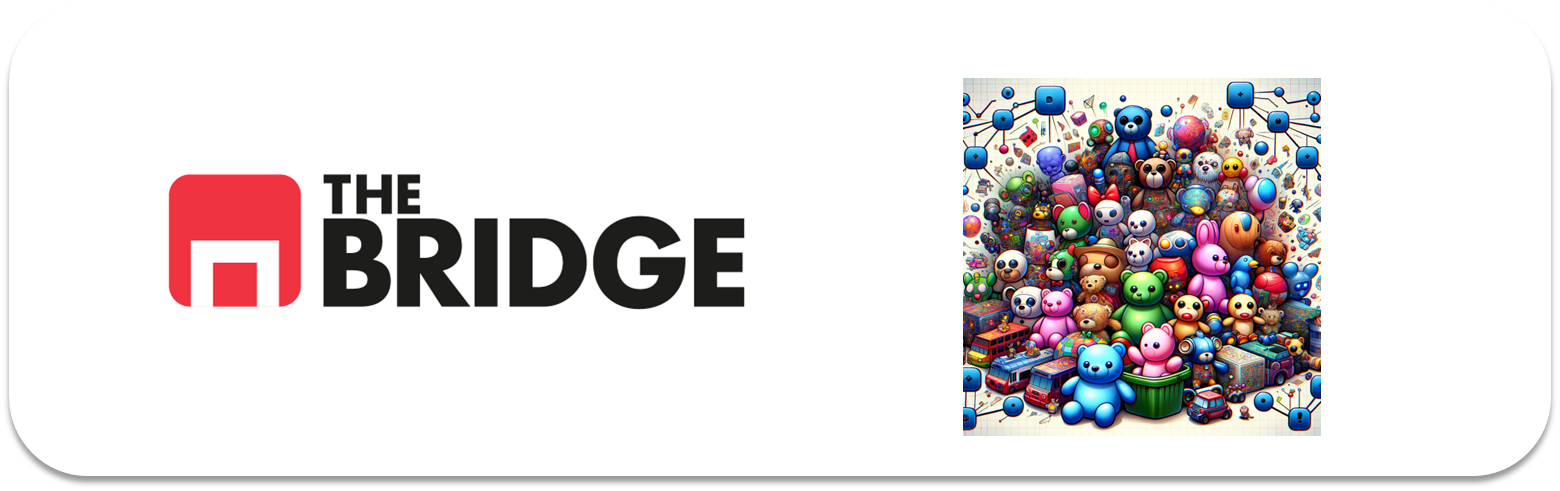

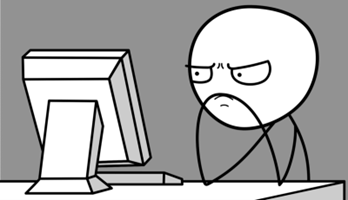

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [155]:
# Common imports
import numpy as np
import os
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


import bootcampviztools as bt
from toolbox_ML import *


### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [115]:

df = pd.read_csv("./data/drugLibTrain_raw.tsv", sep='\t')

df.head(4)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


In [116]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB
None


In [117]:
print(df.describe())


        Unnamed: 0       rating
count  3107.000000  3107.000000
mean   2080.607016     7.006115
std    1187.998828     2.937582
min       0.000000     1.000000
25%    1062.500000     5.000000
50%    2092.000000     8.000000
75%    3092.500000     9.000000
max    4161.000000    10.000000


In [118]:
# Eliminar las columnas innecesarias
df = df.drop(columns='Unnamed: 0')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        3107 non-null   object
 1   rating             3107 non-null   int64 
 2   effectiveness      3107 non-null   object
 3   sideEffects        3107 non-null   object
 4   condition          3106 non-null   object
 5   benefitsReview     3089 non-null   object
 6   sideEffectsReview  3032 non-null   object
 7   commentsReview     3095 non-null   object
dtypes: int64(1), object(7)
memory usage: 194.3+ KB


In [119]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        3107 non-null   object
 1   rating             3107 non-null   int64 
 2   effectiveness      3107 non-null   object
 3   sideEffects        3107 non-null   object
 4   condition          3106 non-null   object
 5   benefitsReview     3089 non-null   object
 6   sideEffectsReview  3032 non-null   object
 7   commentsReview     3095 non-null   object
dtypes: int64(1), object(7)
memory usage: 194.3+ KB


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [120]:
describe_df(df)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
DATE_TYPE,object,int64,object,object,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.03,0.58,2.41,0.39
UNIQUE_VALUES,502,10,5,5,1426,3031,2813,3046
CARDIN (%),16.16,0.32,0.16,0.16,45.91,98.12,92.78,98.42


In [121]:
tipifica_variables(df,10,20)

,nombre_variable,tipo_sugerido
0,urlDrugName,Numérica Discreta
1,rating,Numérica Discreta
2,effectiveness,Categórica
3,sideEffects,Categórica
4,condition,Numérica Continua
5,benefitsReview,Numérica Continua
6,sideEffectsReview,Numérica Continua
7,commentsReview,Numérica Continua


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

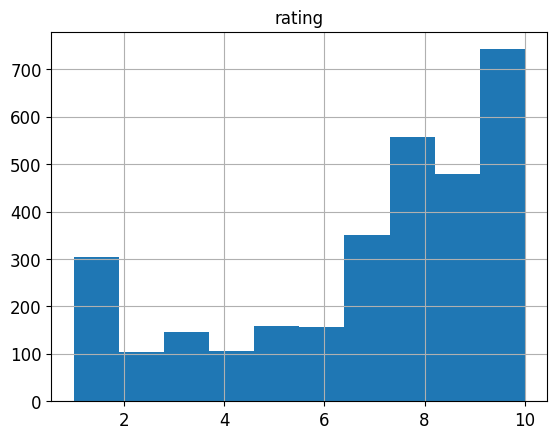

In [122]:
df.hist()
plt.tight_layout

In [123]:
# Mostrar proporciones de valores únicos para cada columna categórica
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Proporciones en la columna '{column}':")
        print(df[column].value_counts(normalize=True))
        print("\n")

Proporciones en la columna 'urlDrugName':
urlDrugName
lexapro      0.020277
prozac       0.014805
retin-a      0.014483
zoloft       0.014483
propecia     0.012230
               ...   
mirena       0.000322
xanax-xr     0.000322
omnitrope    0.000322
cataflam     0.000322
trileptal    0.000322
Name: proportion, Length: 502, dtype: float64


Proporciones en la columna 'effectiveness':
effectiveness
Highly Effective          0.428066
Considerably Effective    0.298680
Moderately Effective      0.133569
Ineffective               0.079498
Marginally Effective      0.060187
Name: proportion, dtype: float64


Proporciones en la columna 'sideEffects':
sideEffects
Mild Side Effects                0.327969
No Side Effects                  0.299324
Moderate Side Effects            0.197618
Severe Side Effects              0.118764
Extremely Severe Side Effects    0.056324
Name: proportion, dtype: float64


Proporciones en la columna 'condition':
condition
depression                             

In [124]:
# Obtén los tipos de datos de cada columna
tipos_de_datos = df.dtypes

# Inicializa listas para almacenar nombres de columnas numéricas y categóricas
columnas_numericas = []
columnas_categoricas = []

# Itera sobre cada columna y clasifícala como numérica o categórica
for columna, tipo in tipos_de_datos.items():
    if pd.api.types.is_numeric_dtype(tipo):
        columnas_numericas.append(columna)
    else:
        columnas_categoricas.append(columna)

# Muestra las columnas numéricas y categóricas
print("Columnas numéricas:")
print(columnas_numericas)
print("\nColumnas categóricas:")
print(columnas_categoricas)

Columnas numéricas:
['rating']

Columnas categóricas:
['urlDrugName', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview']


In [125]:
features_cat=  'effectiveness', 'sideEffects'

In [126]:
features_num = 'rating'

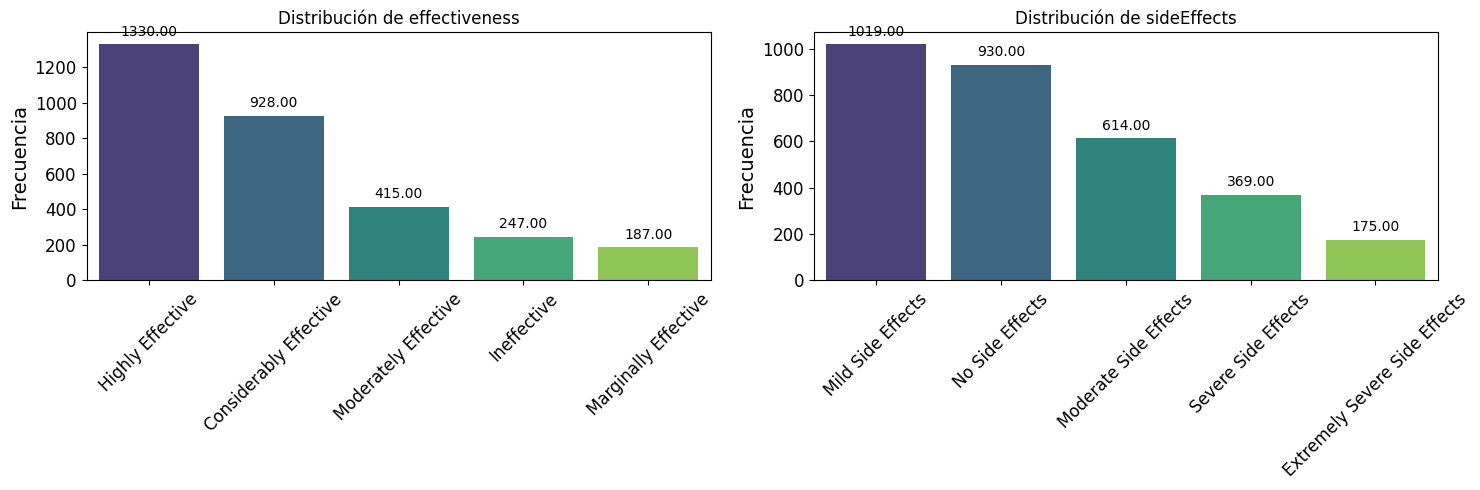

In [127]:
bt.pinta_distribucion_categoricas(df, features_cat, relativa=False, mostrar_valores=True)

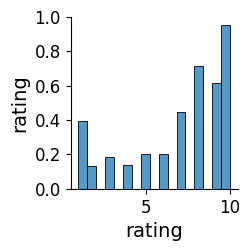

In [128]:
sns.pairplot(df) 

<Axes: xlabel='rating', ylabel='effectiveness'>

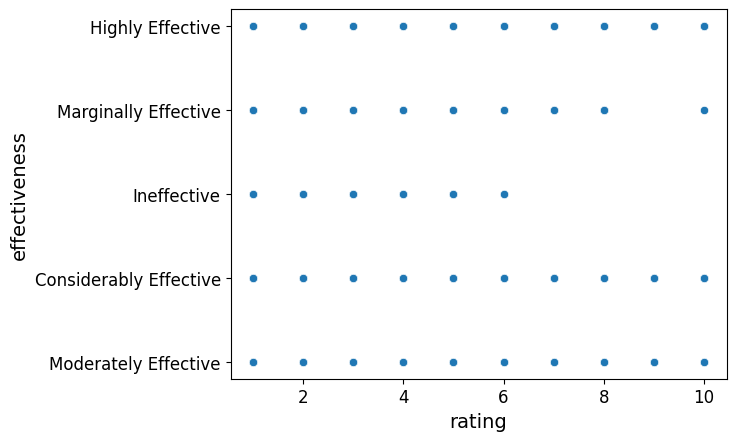

In [129]:

sns.scatterplot(x=df['rating'],
                y=df['effectiveness'])


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [130]:
X = df[['rating', 'sideEffects', 'effectiveness']]
X.head()

,rating,sideEffects,effectiveness
0,4,Mild Side Effects,Highly Effective
1,1,Severe Side Effects,Highly Effective
2,10,No Side Effects,Highly Effective
3,3,Mild Side Effects,Marginally Effective
4,2,Severe Side Effects,Marginally Effective


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [131]:
df['sideEffects'].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

In [132]:
# Definir el mapeo de severidad
severity_mapping = {
    'No Side Effects': 0,
    'Mild Side Effects': 1,
    'Moderate Side Effects': 2,
    'Severe Side Effects': 3,
    'Extremely Severe Side Effects': 4
}
X['sideEffects'] = X['sideEffects'].map(severity_mapping)


C:\Users\mfm-8\AppData\Local\Temp\ipykernel_11652\1181852609.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sideEffects'] = X['sideEffects'].map(severity_mapping)


In [133]:
df['effectiveness'].unique()

array(['Highly Effective', 'Marginally Effective', 'Ineffective',
       'Considerably Effective', 'Moderately Effective'], dtype=object)

In [134]:
# Definir el mapeo de effectiveness
effectiveness_mapping = {
    'Ineffective': 0,
    'Marginally Effective': 1,
    'Moderately Effective': 2,
    'Considerably Effective': 3,
    'Highly Effective': 4
}

# Aplicar el mapeo a la columna 'effectiveness'
X['effectiveness'] = X['effectiveness'].map(effectiveness_mapping)


C:\Users\mfm-8\AppData\Local\Temp\ipykernel_11652\2468103764.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['effectiveness'] = X['effectiveness'].map(effectiveness_mapping)


In [135]:
X

,rating,sideEffects,effectiveness
0,4,1,4
1,1,3,4
2,10,0,4
3,3,1,1
4,2,3,1
...,...,...,...
3102,10,1,4
3103,1,4,0
3104,2,2,1
3105,8,1,3


Se explican Min Max 

In [142]:
minmax = MinMaxScaler()
X[X.columns] = minmax.fit_transform(X)

C:\Users\mfm-8\AppData\Local\Temp\ipykernel_11652\491601390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X.columns] = minmax.fit_transform(X)


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

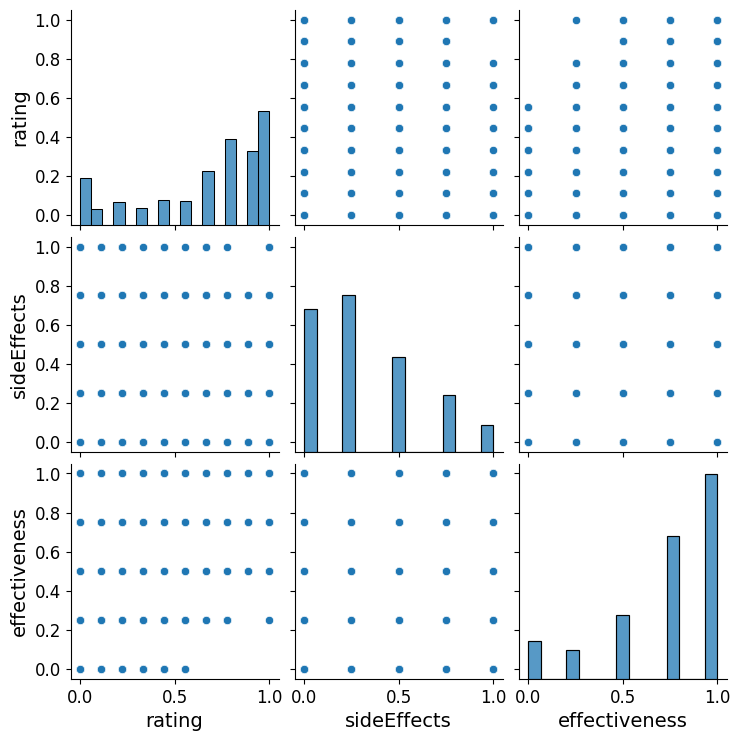

In [143]:
sns.pairplot(X)

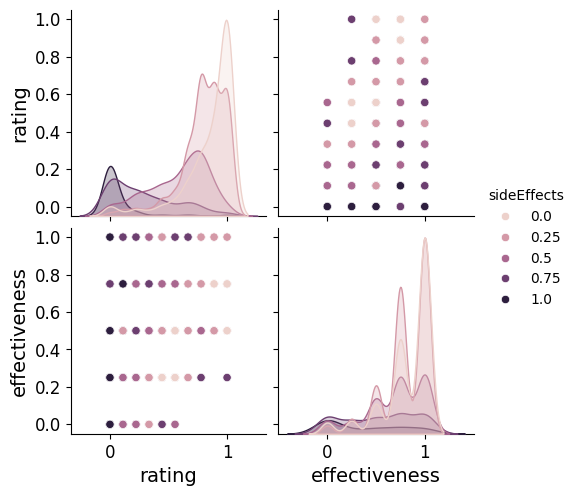

In [144]:
sns.pairplot(X, hue = "sideEffects")


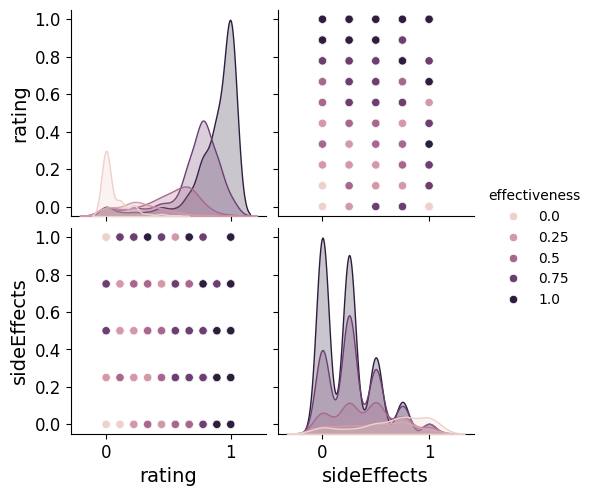

In [145]:
sns.pairplot(X, hue = "effectiveness")

<Axes: xlabel='sideEffects', ylabel='rating'>

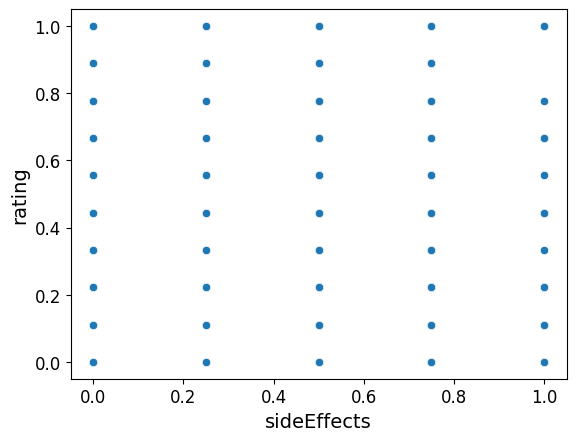

In [147]:
sns.scatterplot(x=X['sideEffects'],
                y=X['rating'])


<Axes: xlabel='effectiveness', ylabel='rating'>

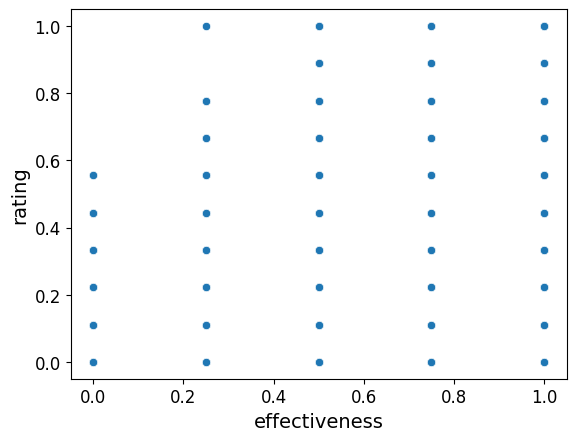

In [148]:
sns.scatterplot(x=X['effectiveness'],
                y=X['rating'])


### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

In [149]:
#Vamos a probar con diferentes valores de k para ver cual es el mejor segun sus inercias y el metodo del codo
ks = []
inertias = []

for k in range(1, 10):
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    ks.append(k)

In [151]:
df_inertias = pd.DataFrame({'k': ks, 'inertia': inertias})
df_inertias

,k,inertia
0,1,893.992575
1,2,395.471897
2,3,301.289974
3,4,242.391818
4,5,198.136668
5,6,165.184749
6,7,158.515116
7,8,118.572493
8,9,108.953593


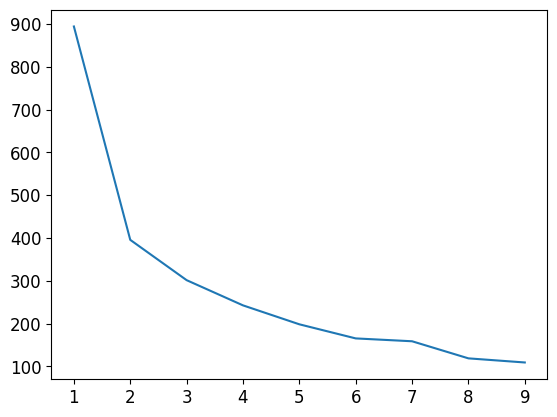

In [152]:
plt.plot(ks, inertias);

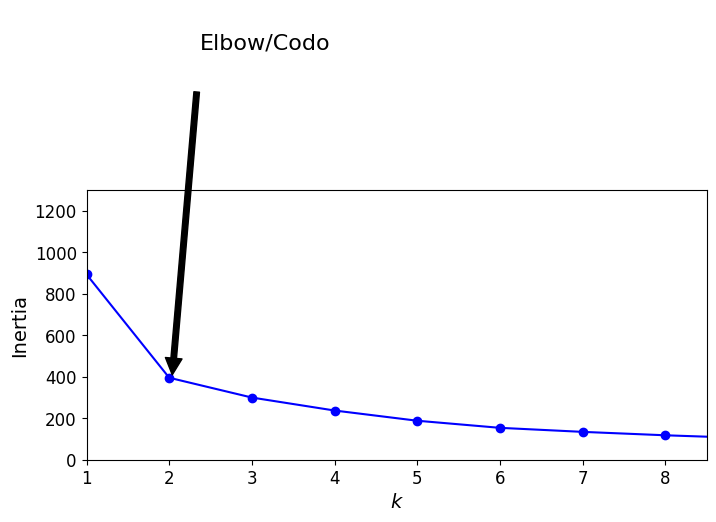

In [165]:
kmeans_per_k = [KMeans(n_clusters=k, random_state= 42, n_init = 25).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]


plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow/Codo',
             xy=(2, inertias[3]),
             xytext=(0.25, 1.35),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()


### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

In [170]:

silhouette_score(X, KMeans.labels_)

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]


plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()


AttributeError: type object 'KMeans' has no attribute 'labels_'

In [171]:
#Calculamos el silhouette score para cada k
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)

    sil_scores.append(silhouette_score(X, clustering.labels_))
    ks.append(k)

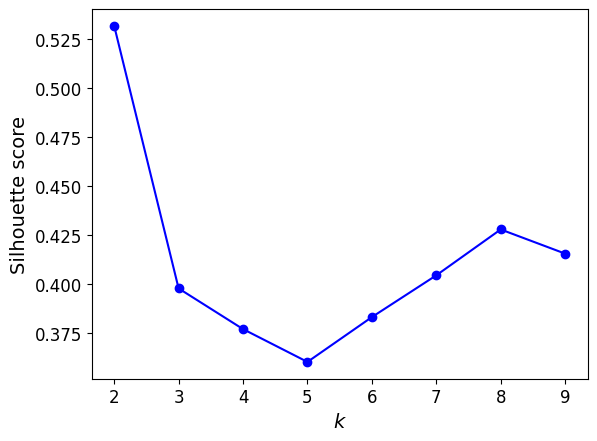

In [172]:
# Graficamos el silhouette score para cada k
plt.plot(ks, sil_scores, "bo-");
plt.xlabel("$k$", fontsize=14);
plt.ylabel("Silhouette score", fontsize=14);

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

In [173]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter


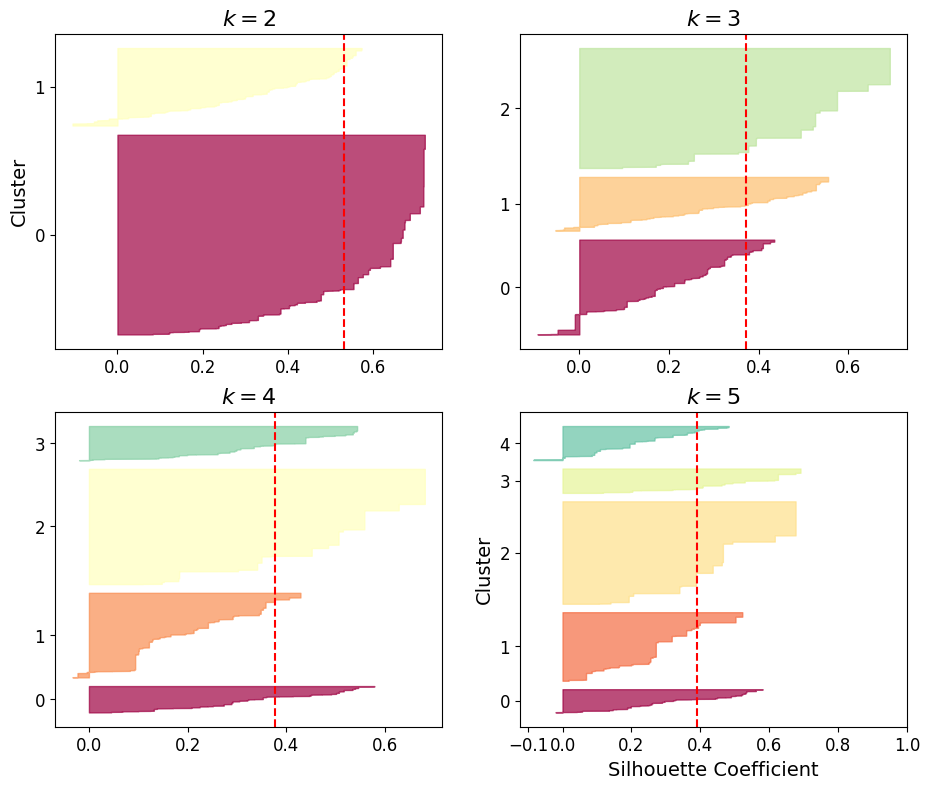

In [179]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()



### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [187]:
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)
def plot_clusterer_comparison(clusterer1, ,clusterer2,clusterer3,clusterer4, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    clusterer3.fit(X)
    clusterer4.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)


SyntaxError: invalid syntax (4050451108.py, line 2)

In [183]:
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k4 = KMeans(n_clusters=4, random_state=42)
kmeans_k5 = KMeans(n_clusters=5, random_state=42)


In [ ]:

plot_clusterer_comparison(kmeans_k2, kmeans_k3, kmeans_k4, kmeans_k5, X, "$k=2$", "$k=3$","$k=4$","$k=5$")
plt.show()

NameError: name 'plot_clusterer_comparison' is not defined


KeyboardInterrupt



In [195]:
clustering_k2 = KMeans(n_clusters= 2)
clustering_k2.fit(X)

KMeans(n_clusters=2)

In [207]:
clustering_k3 = KMeans(n_clusters= 3)
clustering_k3.fit(X)

KMeans(n_clusters=3)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [197]:
X['clusterK2'] = clustering_k2.predict(X)
X.head()

C:\Users\mfm-8\AppData\Local\Temp\ipykernel_11652\2432192058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['clusterK2'] = clustering_k2.predict(X)


,rating,sideEffects,effectiveness,cluster,clusterK2
0,0.333333,0.25,1.00,0,0
1,0.000000,0.75,1.00,1,1
2,1.000000,0.00,1.00,0,0
3,0.222222,0.25,0.25,1,1
4,0.111111,0.75,0.25,1,1


In [204]:
X.describe()

,rating,sideEffects,effectiveness,cluster,clusterK2,cluster3
count,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000
mean,0.667346,0.326199,0.733907,0.269070,0.269070,0.878661
std,0.326398,0.294371,0.307633,0.443548,0.443548,0.846426
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.444444,0.000000,0.500000,0.000000,0.000000,0.000000
50%,0.777778,0.250000,0.750000,0.000000,0.000000,1.000000
75%,0.888889,0.500000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [205]:
X.groupby('clusterK2').describe()

rating                                                              \
            count      mean       std  min       25%       50%       75%  max   
clusterK2                                                                       
0          2271.0  0.838838  0.148709  0.0  0.777778  0.888889  1.000000  1.0   
1           836.0  0.201489  0.197227  0.0  0.000000  0.222222  0.333333  1.0   

          sideEffects            ... cluster      cluster3            \
                count      mean  ...     75%  max    count      mean   
clusterK2                        ...                                   
0              2271.0  0.214993  ...     0.0  0.0   2271.0  0.833994   
1               836.0  0.628289  ...     1.0  1.0    836.0  1.000000   

                                              
                std  min  25%  50%  75%  max  
clusterK2                                     
0          0.986342  0.0  0.0  0.0  2.0  2.0  
1          0.000000  1.0  1.0  1.0  1.0  1.0  

[2 rows x 40 columns]

In [203]:
X['clusterK2'].value_counts(normalize= True)

clusterK2
0    0.73093
1    0.26907
Name: proportion, dtype: float64

In [208]:
X['clusterK3'] = clustering_k3.predict(X)
X.head()

C:\Users\mfm-8\AppData\Local\Temp\ipykernel_11652\3830512798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['clusterK3'] = clustering_k3.predict(X)


,rating,sideEffects,effectiveness,cluster,clusterK2,cluster3,clusterK3
0,0.333333,0.25,1.00,0,0,2,2
1,0.000000,0.75,1.00,1,1,1,0
2,1.000000,0.00,1.00,0,0,0,1
3,0.222222,0.25,0.25,1,1,1,0
4,0.111111,0.75,0.25,1,1,1,0


In [209]:
X['clusterK3'].value_counts(normalize= True)

clusterK3
1    0.426135
2    0.304796
0    0.269070
Name: proportion, dtype: float64

In [211]:
X.groupby('clusterK3').describe()

rating                                                              \
            count      mean       std       min       25%       50%       75%   
clusterK3                                                                       
0           836.0  0.201489  0.197227  0.000000  0.000000  0.222222  0.333333   
1          1324.0  0.848271  0.147171  0.000000  0.777778  0.888889  1.000000   
2           947.0  0.825648  0.149919  0.333333  0.777778  0.888889  1.000000   

               sideEffects            ... clusterK2      cluster3            \
           max       count      mean  ...       75%  max    count mean  std   
clusterK3                             ...                                     
0          1.0       836.0  0.628289  ...       1.0  1.0    836.0  1.0  0.0   
1          1.0      1324.0  0.086480  ...       0.0  0.0   1324.0  0.0  0.0   
2          1.0       947.0  0.394667  ...       0.0  0.0    947.0  2.0  0.0   

                                    
           min  25%  50%  75%  max  
clusterK3                           
0          1.0  1.0  1.0  1.0  1.0  
1          0.0  0.0  0.0  0.0  0.0  
2          2.0  2.0  2.0  2.0  2.0  

[3 rows x 48 columns]

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.